# Ultilities

In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd
import random
import time

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE

# PyTorch
import torch
from torch import nn
from torch.nn import functional as F
from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler, random_split
import torchvision
from torchvision import transforms, models, datasets
from torchvision.transforms import functional as tvf 

# Model
from efficientnet_pytorch import EfficientNet

# Lightning
import pytorch_lightning as pl
from argparse import Namespace
from torch.optim import RMSprop

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Data generator

In [5]:
s = 0.5
data_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomResizedCrop(32,(0.8,1.0)),
                                      transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                                                          transforms.RandomGrayscale(p=0.2)])
                                      ])

In [6]:
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

class ResizedRotation():
    def __init__(self, angle, output_size=(96, 96)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img

class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)

PretrainingDatasetWrapper

In [7]:
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, target_size=(96, 96), real_labels=False):
        super().__init__()
        self.ds = ds
        self.target_size = target_size
        self.real_labels = real_labels
        
        # I will be using network pre-trained on ImageNet first, which uses this normalization.
        # Remove this, if you're training from scratch or apply different transformations accordingly
        self.preprocess = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                   std=[0.5, 0.5, 0.5])])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        
        self.randomize = transforms.Compose([transforms.RandomResizedCrop(target_size, scale=(1/3, 1.0), ratio=(0.3, 2.0)), 
                                             transforms.RandomChoice([transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.Lambda(random_rotate)]), 
                                             transforms.RandomApply([random_resized_rotation], p=0.33),
                                             transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)], p=0.8),
                                             transforms.RandomGrayscale(p=0.2)])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw, labels = self.ds[idx]
        t1 = self.randomize(this_image_raw)
        t2 = self.randomize(this_image_raw)
        t1 = self.preprocess(t1) if preprocess else transforms.ToTensor()(t1)
        t2 = self.preprocess(t2) if preprocess else transforms.ToTensor()(t2)
        labels = labels if self.real_labels else torch.tensor(0)
        return (t1, t2), labels

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

## Contractive Loss

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

## Plot feature

In [ ]:
def plot_features(model, num_class, num_feats, batch_size, vdl):
    feats = np.empty([0, num_feats])
    labels = np.empty(0, dtype=int)
    model.eval()
    with torch.no_grad():
        for (x1, x2), y  in vdl:
            x1 = x1.squeeze().to(device, dtype = torch.float)
            x1_emb, x1_proj = model(x1)
            x1_proj = x1_proj.cpu().numpy()
            feats = np.append(feats, x1_proj, axis=0)
            labels = np.append(labels, y, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(val_size//batch_size))
    
    plt.figure(figsize=(20, 20))
    for i in range(num_class):
        plt.scatter(x_feats[labels[:num_samples]==i,1],x_feats[labels[:num_samples]==i,0],alpha=0.2)
    plt.legend([str(i) for i in range(num_class)], loc=4, ncol=(num_class + 1) // 2)
    plt.show()

## Model

### ImageEmbedding

In [27]:
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b0")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection


# Dataset and DataLoader

In [ ]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"
experiment = "mat"

In [ ]:
# Dataset
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"))
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"))
# Loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset characteristic

In [ ]:
train_size = len(train_set)
val_size = len(val_set)
num_batches = math.floor(train_size/batch_size)
print(f"Train dataset: {train_size}")
print(f"Val dataset: {val_size}")
print(f"Number of batches: {num_batches}")

Train dataset: 52766
Val dataset: 13247
Number of batches: 412


In [ ]:
label_names = train_set.classes
num_class = len(label_names)
print(f"Number of classes: {num_class}")
print(label_names)

Number of classes: 30
['calf', 'canvas', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'jacquard ', 'leather', 'leather+canvas', 'linen', 'lizard', 'microguccissima', 'nubuck', 'nylon', 'ostrich', 'python', 'quilted leather', 'suede', 'suede+leather', 'velvet']


# Model

Load model

In [30]:
model = ImageEmbedding()
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


Feature visualization

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


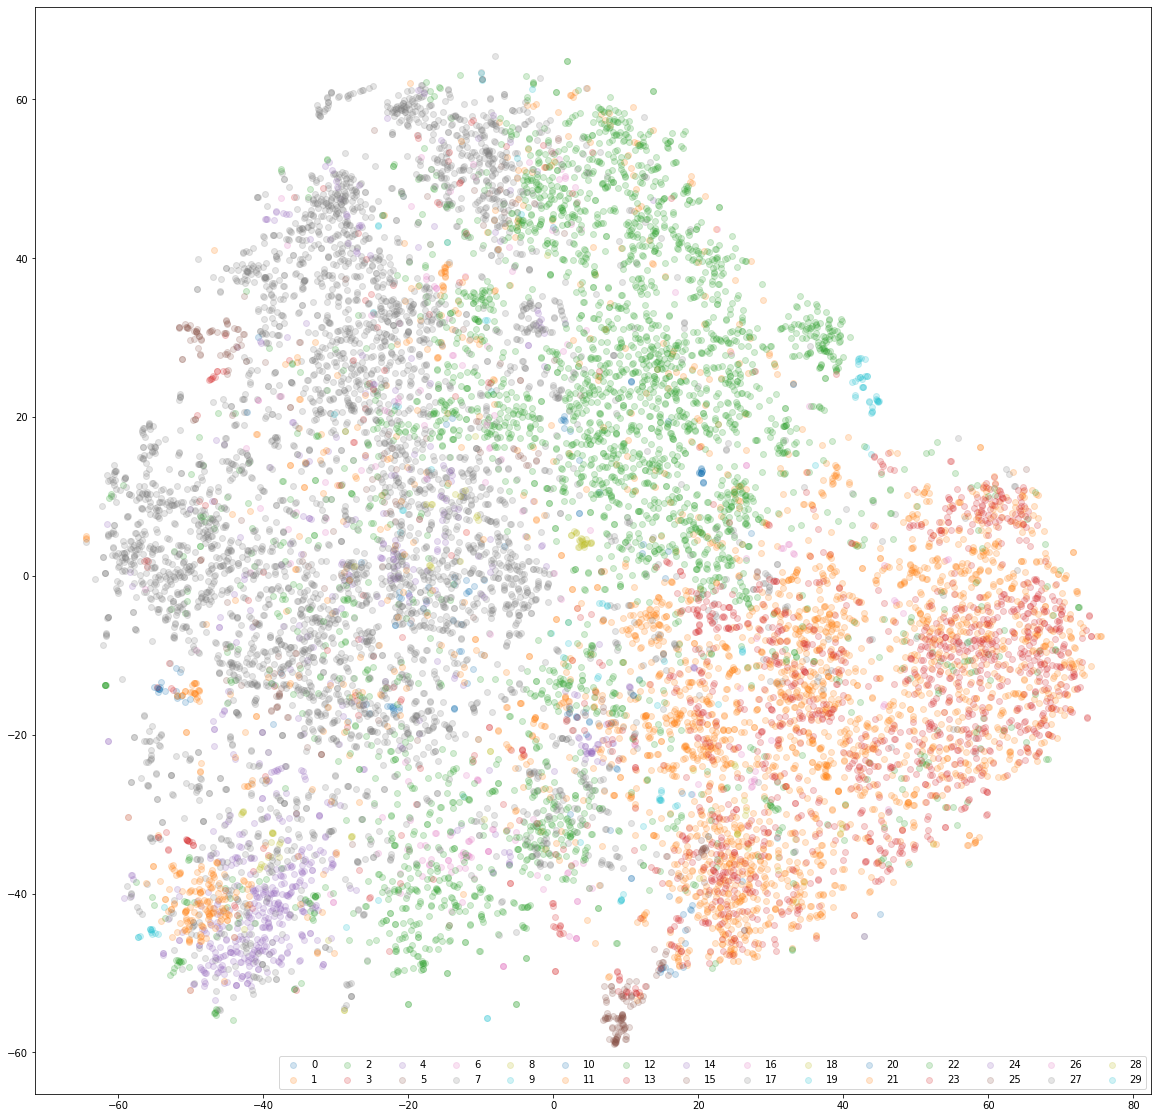

In [32]:
vld_labels = DataLoader(PretrainingDatasetWrapper(val_set, real_labels=True),
                        batch_size=128, 
                        shuffle=False, 
                        num_workers=cpu_count(),
                        drop_last=True)
plot_features(model, num_class, 1024, 128, vld_labels)

# Train module

In [35]:


class LitEmbedding(pl.LightningModule):
	def __init__(self, model, train_set, val_set, lr, batch_size, temperature, epochs):
		super().__init__()
		self.model = model
		self.train_set = train_set
		self.val_set = val_set
		self.train_size = len(train_set)
		self.val_size = len(val_set)
		self.lr = lr
		self.loss = ContrastiveLoss(batch_size, temperature)
		self.epochs = epochs
		self.batch_size = batch_size
	
	def configure_optimizers(self):
		optimizer = RMSprop(self.model.parameters(), lr=self.lr)
		return [optimizer], []
	
	def total_steps(self):
		 return len(self.train_dataloader()) // self.epochs
  
	def train_dataloader(self):
		return DataLoader(PretrainingDatasetWrapper(self.train_set),
                        batch_size=self.batch_size, 
                        # shuffle=True, 
                        num_workers=cpu_count(),
                        sampler=SubsetRandomSampler(list(range(self.train_size))),
                        drop_last=True)
	
	def val_dataloader(self):
		return DataLoader(PretrainingDatasetWrapper(self.val_set, real_labels=True),
                        batch_size=self.batch_size, 
                        shuffle=False, 
                        num_workers=cpu_count(),
                        sampler=SequentialSampler(list(range(self.val_size))),
                        drop_last=True)
	 
	def forward(self, x):
		return self.model(x)

	def step(self, batch, step_name = "train"):
		(t1, t2), _ = batch
		t1_emb, t1_proj = self.forward(t1)
		t2_emb, t2_proj = self.forward(t2)
		loss = self.loss(t1_proj, t2_proj)
		loss_key = f"{step_name}_loss"
		return {
      		("loss" if step_name == "train" else loss_key): loss, 
      		"log": {loss_key: loss},
      		"progress_bar": {loss_key: loss}
      		}
		
	def training_step(self, batch, batch_idx):
		return self.step(batch, "train")

	def validation_step(self, batch, batch_idx):
		return self.step(batch, "val")

	def validation_end(self, outputs):
		if len(outputs) == 0:
			return {"val_loss": torch.tensor(0)}
		else:
			loss = torch.stack([x["val_loss"] for x in outputs]).mean()
			return {"val_loss": loss, "log": {"val_loss": loss}}

In [ ]:
lr = 0.001
epochs = 100
temperature = 0.5
batch_size = 128
criterion = ContrastiveLoss(batch_size = 128, temperature = 0.5)

In [36]:
module = LitEmbedding(model, train_set, val_set, lr, batch_size, temperature, epochs)
t = pl.Trainer(gpus=1)
lr_finder = t.tuner.lr_find(module)

NameError: name 'lr' is not defined

0.0007585775750291836

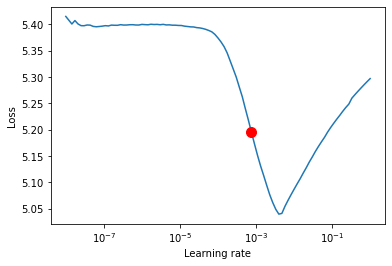

In [ ]:
lr_finder.plot(show=False, suggest=True)
lr_finder.suggestion()

In [38]:
tuned_lr = 0.000758

In [41]:
module = LitEmbedding(model, train_set, val_set, tuned_lr, batch_size, temperature, epochs)
trainer = pl.Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [42]:
trainer.fit(module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | ImageEmbedding  | 6.4 M 
1 | loss  | ContrastiveLoss | 0     
------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.476    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


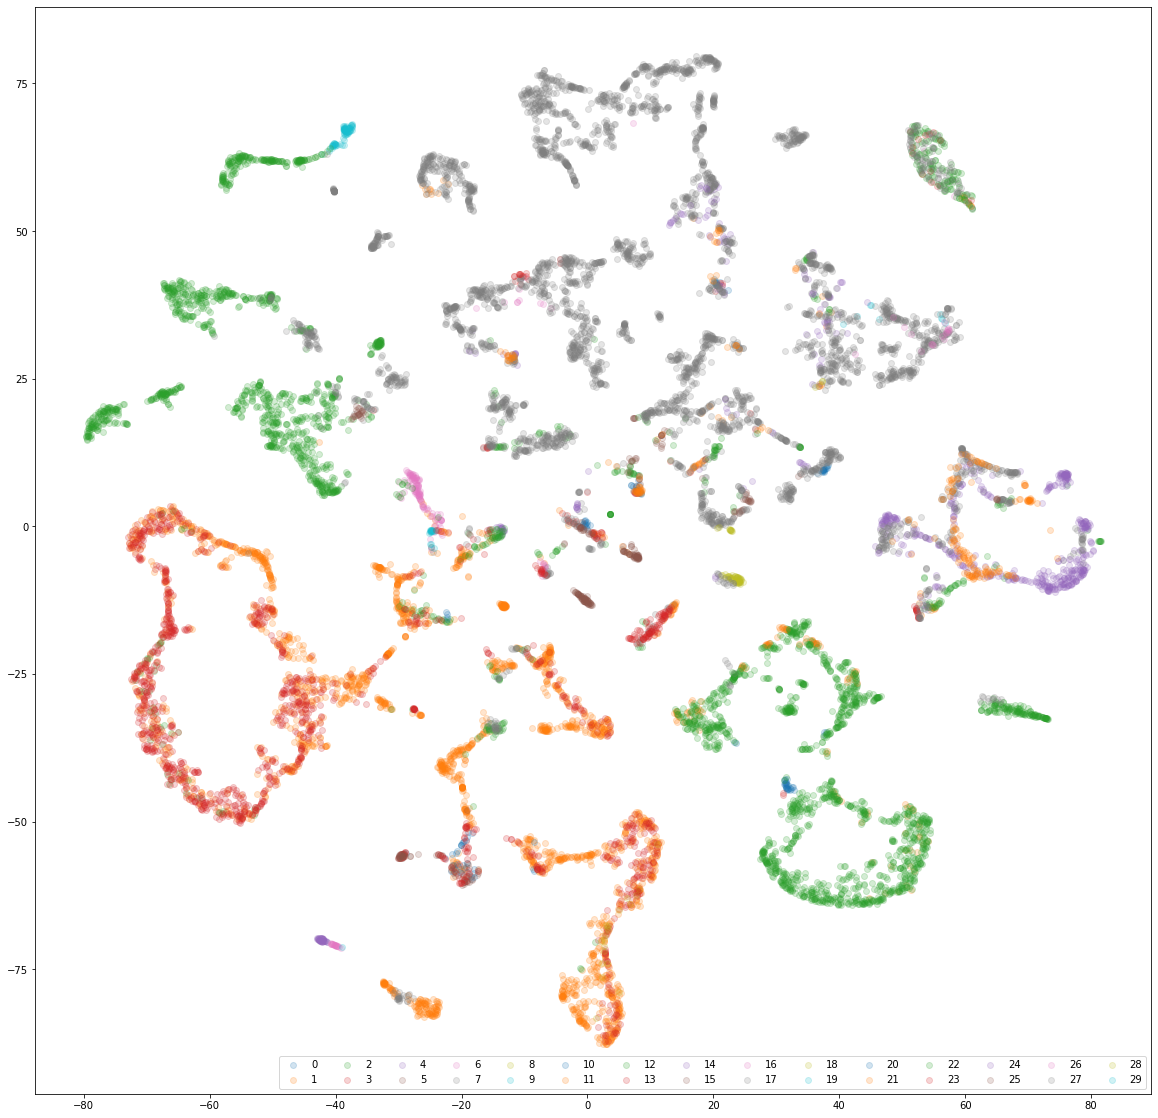

In [33]:
plot_features(model, num_class, 1024, 128, vld_labels)

In [39]:
# Save model parameters
params_path = "exp/RMSprop30"
torch.save(model.state_dict(), params_path)

In [32]:
params_path = "exp/RMSprop30"
model.load_state_dict(torch.load(params_path))
model.eval()

ImageEmbedding(
  (embedding): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
     